# Encoding Comparison for UI Logs

We are investigating the methods used in the paper title "Enabling Routine Discovery from High-Noise UI Logs: A Time Series Data Mining Approach".
We implemented and tested three methods:
 - Continuous Hot Encoding, which just assigns every unique instance occured an ID or takes the ID previously assigned
 - Co-Occurance Encoding, based on the second Eigenvector, called Fielder-Vector, describing the co-occurance pattern
 - UI Hierarchy Based Encoding, starting of the Abb/Rehse Reference Model to align attributes relevant for encoding 


In [1]:
import pandas as pd
import stumpy
import numpy as np
import time
import util.util
import matplotlib.pyplot as plt

# ---- Set the Data Path for the csv files used for the data sampling and where the logs should be added ----
csvPath = "logs/smartRPA/OriginalAgostinelliLogs/"
validation_path = csvPath + "experiment/"

### Creating a reference Log

We create reference logs to answer two questions:
 1. How do the encoding approaches differ and what are the differences in the time series?
 2. How succesfull is each time series encoding for motif discovery?

In [2]:
# Config
randomness = [1] # Length of sampling sequence, when creating the baseline log (1=> only one event inserted, 2=> sequences of 2 from all possible events inserted ...)
samplingLength = 5000
# Define the ranges and indices where the rows will be inserted
additional_indices = [1000, 2000, 3000, 4000]


# ---- Gathering of unique events until the upper limit is reached ----
dfAll = util.util.read_csvs_and_combine(csvPath,1000000)
# Drop duplicates based on equality assumption in https://doi.org/10.1016/j.compind.2022.103721          
ContextColumns =["category","application","concept:name","event_src_path","event_dest_path","browser_url","xpath"]
df_unique = dfAll.drop_duplicates(subset=ContextColumns)

# Sample the UI log from all available data
uiLog = []
uiLog = util.util.get_rand_uiLog(df_unique, n_max=randomness[0], actions=int(samplingLength)) # set to actions=l for proper work

print(f"UI Log of length {len(uiLog)} is sampled.")

# Extract the first 10 rows from df_unique
rows_to_insert = df_unique.iloc[:10].reset_index(drop=True)

# Ensure uiLog is large enough to accommodate these indices
max_index = max(additional_indices)
if max_index >= len(uiLog):
    print("The uiLog dataframe needs more rows to accommodate the insertion.")
else:
    # Insert rows for 200, 300, 400
    for idx in additional_indices:
        uiLog.iloc[idx:idx + 10] = rows_to_insert.values

print("Rows inserted successfully.")

UI Log of length 5000 is sampled.
Rows inserted successfully.


### Plot all three encoding variants and how they differ

In [2]:
# SMART RPA log

# Optional if an existing log should be used
file_path = 'logs/Banking/'  # Replace with your file path
file_name = "RunningExampleSmartRPA_Anonymized.csv"
uiLog = pd.read_csv(file_path + file_name,sep=";")
ContextColumns =["category","application","concept:name","event_src_path","event_dest_path","browser_url","xpath"]

# Tockler Log
# file_path = 'logs/Banking/'  # Replace with your file path
# file_name = "RunningExampleTockler_Anonymized.csv"
# ContextColumns = ["App","Title"]
# uiLog = pd.read_csv(file_path + file_name,sep=";")

In [3]:
hierarchyEncodedUiLog = []
hierarchyEncodedUiLog = util.util.encoding_UiLog(uiLog,orderedColumnsList=ContextColumns,encoding=1)
hierarchyEncodedUiLog = hierarchyEncodedUiLog.reset_index(drop=True)

cooccurancyEncodedUiLog = []
cooccurancyEncodedUiLog = util.util.encoding_UiLog(uiLog,orderedColumnsList=ContextColumns,encoding=2)
cooccurancyEncodedUiLog = cooccurancyEncodedUiLog.reset_index(drop=True)

HotEncodedUiLog = []
HotEncodedUiLog = util.util.encoding_UiLog(uiLog,orderedColumnsList=ContextColumns,encoding=3)
HotEncodedUiLog = HotEncodedUiLog.reset_index(drop=True)

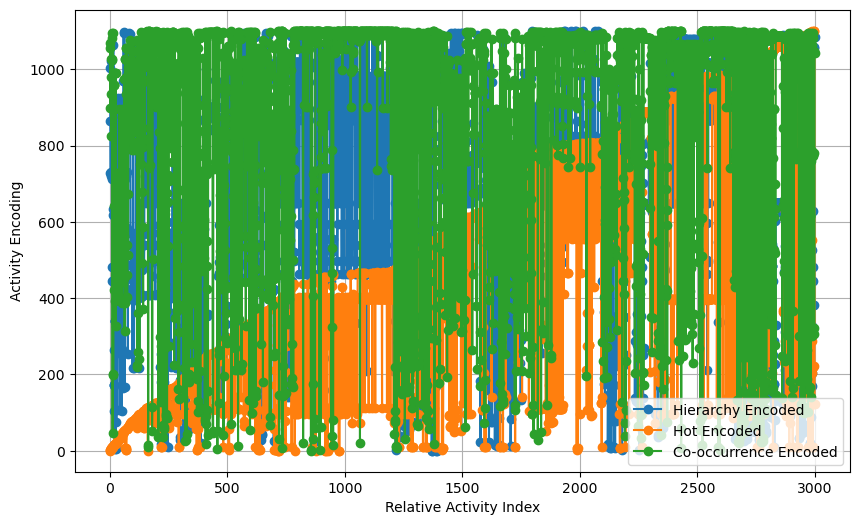

[[3.31697304e-06 4.32054848e+00 4.42700539e+00 4.43210812e+00
  4.44998699e+00 4.59363979e+00 4.69313976e+00 4.75523605e+00
  4.78538739e+00 4.85934142e+00]]
[[2.57057318e-04 2.38208135e-04 1.72570923e+00 1.97444704e+00
  2.40683037e+00 2.66226499e+00 2.89570113e+00 2.91233228e+00
  2.99957332e+00 3.04104781e+00]]
[[1.62210621e-06 4.03747603e-01 5.86090679e-01 7.30788130e-01
  1.17553865e+00 1.25677047e+00 1.64829064e+00 1.65652238e+00
  2.16044429e+00 2.59082859e+00]]


,Log Name,Median Value (Range 100-110),Median Difference (Range 100-110),Median Difference (Whole Log),Sample Variance,Top Motifs,Discovery Score
0,Hierarchy Encoded,712.0,0.0,0.0,79641.637471,"[[417, 2738, 1618, 726, 104, 1362, 1466, 988, ...","[[3.3169730439114666e-06, 4.3205484814349155, ..."
1,Hot Encoded,399.0,1.0,1.0,97178.135699,"[[2831, 2269, 2429, 69, 292, 382, 1724, 1417, ...","[[0.00025705731835918373, 0.000238208135380906..."
2,Co-occurrence Encoded,1017.0,0.0,0.0,96902.356122,"[[1145, 1165, 1048, 1078, 806, 2012, 1121, 180...","[[1.6221062136499018e-06, 0.40374760290336703,..."


In [4]:
# Define the dataframes
logs = {
    "Hierarchy Encoded": hierarchyEncodedUiLog,
    "Hot Encoded": HotEncodedUiLog,
    "Co-occurrence Encoded": cooccurancyEncodedUiLog
}

# ---- Creating the plot ----
# Define the range to plot 1234 to 1281
range_block = list(range(0, 3000))

# Initialize the plot
plt.figure(figsize=(10, 6))

# Iterate through each log and plot the specified range
for log_name, log_df in logs.items():
    # Ensure all indices exist in the log
    missing_indices = [idx for idx in range_block if idx not in log_df.index]
    if missing_indices:
        print(f"Skipping {log_name}: Missing indices {missing_indices}")
        continue

    # Extract values from the 'tuple:id' column for the current log
    values = log_df.loc[range_block, 'tuple:id']

    # Plot the values with a label
    plt.plot(list(range(0, 3000)), values.values, marker='o', linestyle='-', label=log_name)

# Add labels, title, and legend
plt.xlabel("Relative Activity Index")
plt.ylabel("Activity Encoding")
# plt.title("Comparison of a artificially  inserted routine")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

# ---- Calculate statistical measures ----
# Initialize a results list
results = []

# Perform calculations for each log
for log_name, log_df in logs.items():
    # Ensure the indices exist in the dataframe
    missing_indices = [idx for idx in range_block if idx not in log_df.index]
    if missing_indices:
        print(f"Skipping {log_name}: Missing indices {missing_indices}")
        continue

    else:
        # Extract the relevant rows
        subset = log_df.loc[range_block, 'tuple:id']
        
        # Calculate the median value for the range
        median_value_range = subset.median()
        
        # Calculate the consecutive differences and their median for the range
        differences_range = subset.diff().dropna()
        median_difference_range = differences_range.median()
    
    # Calculate the median difference for the entire log
    differences_whole_log = log_df['tuple:id'].diff().dropna()
    median_difference_whole_log = differences_whole_log.median()

    # Calculate the sample variance for the log // https://d1wqtxts1xzle7.cloudfront.net/57257340/27643868-libre.pdf?1535423670=&response-content-disposition=inline%3B+filename%3DTeachers_Corner_Sample_Mean_and_Sample_V.pdf&Expires=1734105390&Signature=Pcj84QOGqmtZkaNF00yMT8yelfqZtEMPcCUbvRVPnXfj2IcegZ8Ld9vYeRbMbxS1PvxpQmhAQbtxm4YU7vEri318urdWqPxbtBUHXH3ZsjqbdTsgVIdMPhUUpXkT4Ho21CQraUlImfGJyYYBFmi9wclEp9A8CkV-3N~KE~fIrqZWPJrK~QWyHjpYseJKDkQKfkBI36YpSJVNSDSF5i3hsO5s3~rdyQLNHfW18gDVl0oMA236zhGrge2joh5leFBPOoRBi65NDnk4vCL-lutcAFFyxzubl4uGneDJf9sZB5E9ho0gcozt~gAFc0jguyjiE2crCNH5j~H7aPL-dN~1tg__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA
    mean_range = log_df['tuple:id'].mean()
    sample_variance = ((log_df['tuple:id'] - mean_range) ** 2).sum() / (len(log_df['tuple:id']) - 1)
    
    # Generate the matrix profil
    tm_matrix, event_series = util.util.discover_motifs(log_df, 25, normalize=False)
    top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=10)

    # Append results to the list
    results.append({
        "Log Name": log_name,
        "Median Value (Range 100-110)": median_value_range,
        "Median Difference (Range 100-110)": median_difference_range,
        "Median Difference (Whole Log)": median_difference_whole_log,
        "Sample Variance": sample_variance,
        "Top Motifs": top_motifs[1],
        "Discovery Score": top_motifs[0]
    })
    print(top_motifs[0])

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

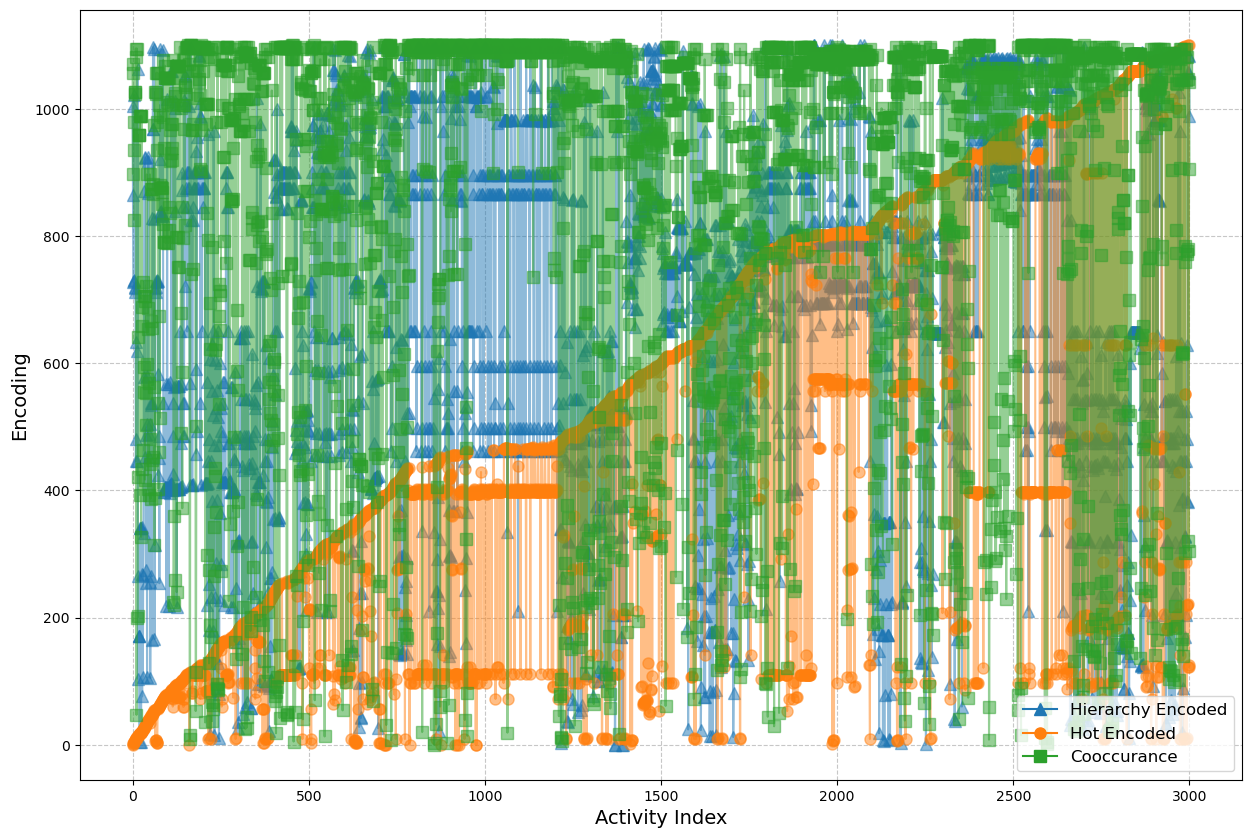

In [5]:
# Function to plot tuple:id from three dataframes
def plot_tuple_ids(df1, df2, df3):
    plt.figure(figsize=(15, 10))

    # Plot tuple:id for each dataframe
    plt.plot(df1['tuple:id'], label='Hierarchy Encoded', marker='^', markersize=8)
    plt.plot(df2['tuple:id'], label='Hot Encoded', marker='o', markersize=8)
    plt.plot(df3['tuple:id'], label='Cooccurance', marker='s', markersize=8)
    

    # Adding titles and labels
    #plt.title('Comparison of Tuple:ID Across Encoding Methods', fontsize=16)
    plt.xlabel('Activity Index', fontsize=14)
    plt.ylabel('Encoding', fontsize=14)

    # Adding legend
    plt.legend(fontsize=12)

    # Adding grid for better readability
    plt.grid(linestyle='--', alpha=0.7)

    # Save the plot to a file
    # plt.savefig('tuple_id_comparison.png', dpi=300, bbox_inches='tight')
    
    # Reduce the opacity of the lines
    for line in plt.gca().get_lines():
        line.set_alpha(0.5)
    # Show the plot
    plt.show()
    

# Call the function
plot_tuple_ids(hierarchyEncodedUiLog, HotEncodedUiLog, cooccurancyEncodedUiLog)

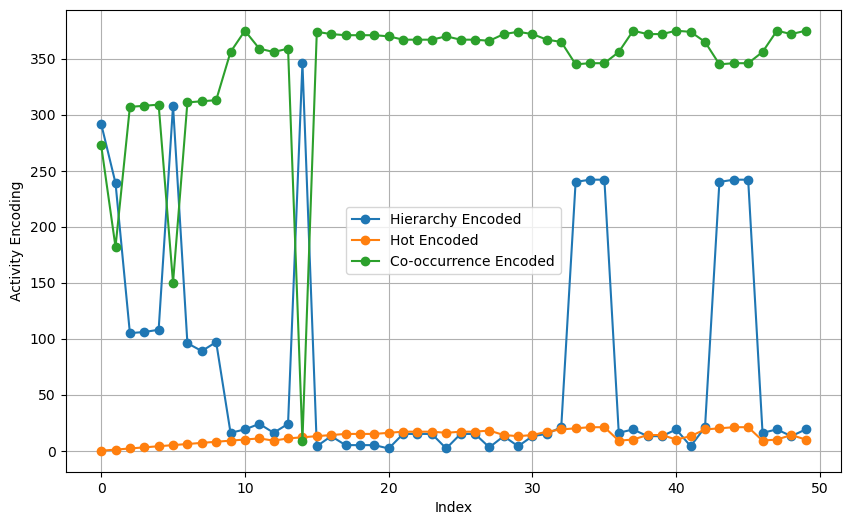

,Log Name,Min Value,Max Value
0,Hierarchy Encoded,0,376
1,Hot Encoded,0,376
2,Co-occurrence Encoded,0,376


In [7]:
# Plot the first n elements of the `tuple:id` column for each dataframe
plt.figure(figsize=(10, 6))

for log_name, log_df in logs.items():
    # Check if the column `tuple:id` exists
    if 'tuple:id' not in log_df.columns:
        print(f"Skipping {log_name}: 'tuple:id' column not found.")
        continue
    
    # Extract the first n elements
    n = 50
    subset = log_df['tuple:id'].iloc[:n]
    
    # Plot the `tuple:id` column
    plt.plot(subset.index, subset.values, marker='o', linestyle='-', label=log_name)

# Add labels, title, and legend
plt.xlabel("Index")
plt.ylabel("Activity Encoding")
# plt.title(f"First {n} encoded activities per encoding")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

# Initialize a results list
results = []

# Calculate the min and max for each log
for log_name, log_df in logs.items():
    # Check if the column `tuple:id` exists
    if 'tuple:id' not in log_df.columns:
        print(f"Skipping {log_name}: 'tuple:id' column not found.")
        continue
    
    # Calculate min and max
    min_value = log_df['tuple:id'].min()
    max_value = log_df['tuple:id'].max()
    
    # Append results
    results.append({
        "Log Name": log_name,
        "Min Value": min_value,
        "Max Value": max_value
    })

# Convert results to a DataFrame
min_max_df = pd.DataFrame(results)
min_max_df

In [7]:
cooccurancyEncodedUiLog

,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_relevance,event_src_path,...,xpath_full,screenshot,category:id,application:id,concept:name:id,event_src_path:id,event_dest_path:id,browser_url:id,xpath:id,tuple:id
0,605082223346000,SmartRPA by marco2012,complete,2024-06-05T08:22:23.346,researcher,OperatingSystem,Task Switching,hotkey,NaN,NaN,...,NaN,NaN,1,25,7,127,12,0,256,0
1,605082223346000,SmartRPA by marco2012,complete,2024-06-05T08:22:24.073,researcher,OperatingSystem,EXCEL.EXE,programOpen,NaN,C:\Program Files\Microsoft Office\root\Office1...,...,NaN,NaN,1,68,2,89,12,0,256,1
2,605082223346000,SmartRPA by marco2012,complete,2024-06-05T08:22:25.459,researcher,MicrosoftOffice,Microsoft Word,activateWindow,NaN,NaN,...,NaN,NaN,3,10,27,127,12,0,256,2
3,605082223346000,SmartRPA by marco2012,complete,2024-06-05T08:22:25.512,researcher,MicrosoftOffice,Microsoft Word,changeDocument,NaN,NaN,...,NaN,NaN,3,10,42,127,12,0,256,3
4,605082223346000,SmartRPA by marco2012,complete,2024-06-05T08:22:25.530,researcher,MicrosoftOffice,Microsoft Word,newDocument,NaN,NaN,...,NaN,NaN,3,10,44,127,12,0,256,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,614090408631000,SmartRPA by marco2012,complete,2024-06-14T09:55:52.476,researcher,OperatingSystem,updater.exe,programOpen,NaN,C:\Program Files (x86)\Google\GoogleUpdater\12...,...,NaN,NaN,1,18,2,119,12,0,256,122
2997,614090408631000,SmartRPA by marco2012,complete,2024-06-14T09:55:54.539,researcher,OperatingSystem,officesvcmgr.exe,programOpen,NaN,NaN,...,NaN,NaN,1,118,2,127,12,0,256,1100
2998,614090408631000,SmartRPA by marco2012,complete,2024-06-14T09:55:58.615,researcher,OperatingSystem,officesvcmgr.exe,programClose,NaN,NaN,...,NaN,NaN,1,118,5,127,12,0,256,1101
2999,614090408631000,SmartRPA by marco2012,complete,2024-06-14T09:56:02.561,researcher,OperatingSystem,updater.exe,programClose,NaN,NaN,...,NaN,NaN,1,18,5,127,12,0,256,123
